<a href="https://colab.research.google.com/github/Negus25/Demo/blob/main/mnist_lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install d2l==0.17.0
!pip install -U mxnet-cu101==1.7.0

     |████████████████████████████████| 83 kB 713 kB/s 
     |███████████████████████████████▌| 834.1 MB 1.4 MB/s eta 0:00:09tcmalloc: large alloc 1147494400 bytes == 0x55708f754000 @  0x7f4f43832615 0x5570552f302c 0x5570553d317a 0x5570552f5e4d 0x5570553e7c0d 0x55705536a0d8 0x557055364c35 0x5570552f773a 0x557055369f40 0x557055364c35 0x5570552f773a 0x55705536693b 0x5570553e8a56 0x557055365fb3 0x5570553e8a56 0x557055365fb3 0x5570553e8a56 0x557055365fb3 0x5570552f7b99 0x55705533ae79 0x5570552f67b2 0x557055369e65 0x557055364c35 0x5570552f773a 0x55705536693b 0x557055364c35 0x5570552f773a 0x557055365b0e 0x5570552f765a 0x557055365d67 0x557055364c35
     |████████████████████████████████| 846.0 MB 23 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


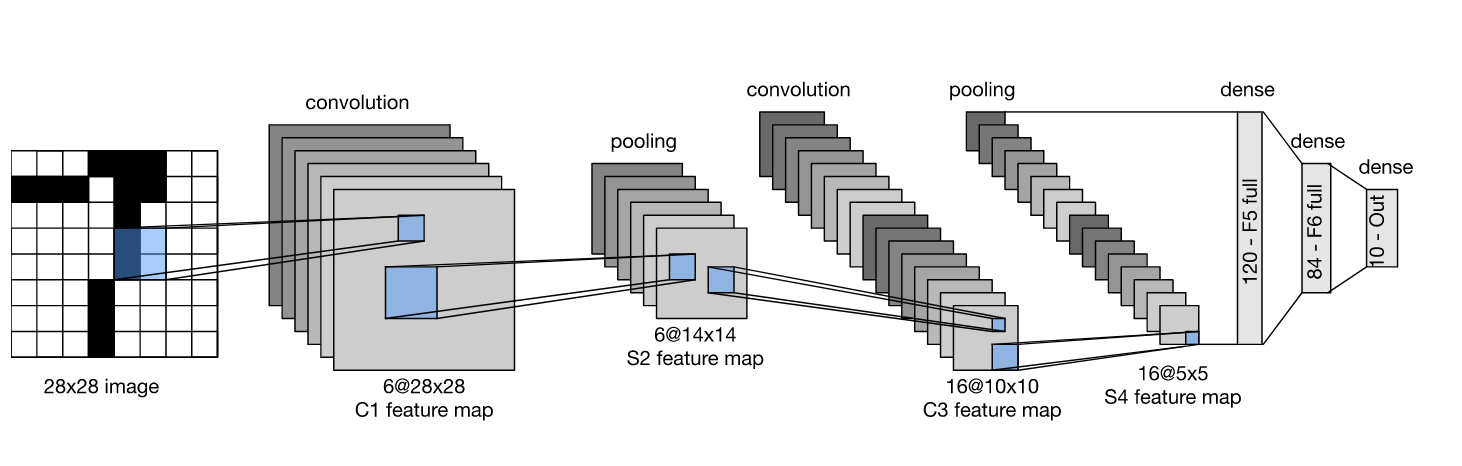

In [30]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

net = nn.Sequential()
net.add(
    nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
    nn.AvgPool2D(pool_size=2, strides=2),
    nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
    nn.AvgPool2D(pool_size=2, strides=2),
    # `Dense` will transform an input of the shape (batch size, number of
    # channels, height, width) into an input of the shape (batch size,
    # number of channels * height * width) automatically by default
    nn.Dense(120, activation='sigmoid'), nn.Dense(84, activation='sigmoid'),
    nn.Dense(10))

In [32]:
X = np.random.uniform(size=(1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv2 output shape:	 (1, 6, 28, 28)
pool2 output shape:	 (1, 6, 14, 14)
conv3 output shape:	 (1, 16, 10, 10)
pool3 output shape:	 (1, 16, 5, 5)
dense3 output shape:	 (1, 120)
dense4 output shape:	 (1, 84)
dense5 output shape:	 (1, 10)


/usr/local/lib/python3.7/dist-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'conv2_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'conv2_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'conv3_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'conv3_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.7/dist-packages/mxnet

In [7]:
d2l.use_svg_display()

In [6]:
mnist_train = gluon.data.vision.MNIST(train=True)
mnist_test = gluon.data.vision.MNIST(train=False)

In [8]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [9]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): 
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

(18, 28, 28, 1)
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8]


ValueError: ignored

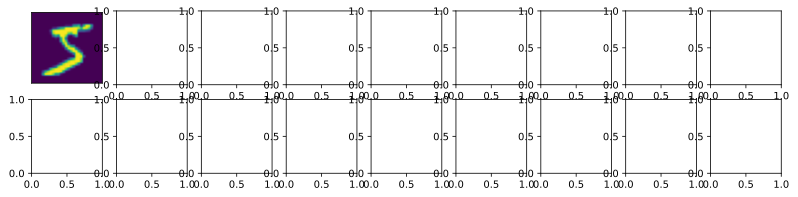

In [10]:
X, y = mnist_train[:18]

print(X.shape)
print(y)
show_images(X.squeeze(axis=-1), 2, 9, y);

In [11]:
def load_data_mnist(batch_size, resize=None):  
    """Download the MNIST dataset and then load it into memory."""
    dataset = gluon.data.vision
    trans = [dataset.transforms.ToTensor()]
    if resize:
        trans.insert(0, dataset.transforms.Resize(resize))
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.MNIST(train=True).transform_first(trans)
    mnist_test = dataset.MNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False))

In [12]:
train_iter, test_iter = load_data_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

(32, 1, 64, 64) float32 (32,) int32


In [33]:
batch_size = 256
train_iter, test_iter = load_data_mnist(batch_size)

In [14]:
class Accumulator: 
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
def accuracy(y_hat, y): 
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.astype(y.dtype) == y
    return float(cmp.astype(y.dtype).sum())

In [16]:
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """Compute the accuracy for a model on a dataset using a GPU."""
    if not device:  # Query the first device where the first parameter is on
        device = list(net.collect_params().values())[0].list_ctx()[0]
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.as_in_ctx(device), y.as_in_ctx(device)
        metric.add(accuracy(net(X), y), y.size)
    return metric[0] / metric[1]

In [34]:
evaluate_accuracy_gpu(net, test_iter)

0.0982

In [35]:

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    net.initialize(force_reinit=True, ctx=device, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            # Here is the major difference from `d2l.train_epoch_ch3`
            X, y = X.as_in_ctx(device), y.as_in_ctx(device)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
        animator.add(epoch + 1, (None, None, test_acc))

    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

23706.9 examples/sec on gpu(0)


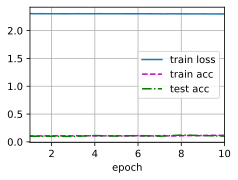

In [36]:
lr, num_epochs = 0.1, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [37]:
def get_mnist_labels(labels):  
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = [
        '0', '1', '2', '3', '4', '5', '6',
        '7', '8', '9']
    return [text_labels[int(i)] for i in labels]

In [43]:
def predict_ch3(net, test_iter, n=6):
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
        trues = (y)
        preds = net(X).argmax(axis=1)
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

UnboundLocalError: ignored

In [44]:
evaluate_accuracy_gpu(net, test_iter)

0.1028

In [45]:
int(evaluate_accuracy_gpu(net, test_iter)*10000)

1028

In [27]:
pip install -U d2l

23656.2 examples/sec on gpu(0)


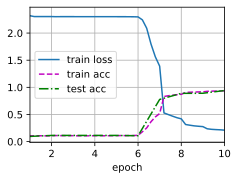

In [28]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [46]:
evaluate_accuracy_gpu(net, test_iter)

0.1028

24128.5 examples/sec on gpu(0)


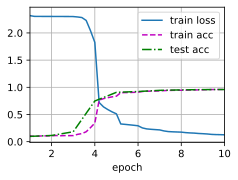

In [47]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [48]:
evaluate_accuracy_gpu(net, test_iter)

0.9595

In [65]:

net = nn.Sequential()
net.add(
    nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
    nn.MaxPool2D(pool_size=2, strides=2),
    # `Dense` will transform an input of the shape (batch size, number of
    # channels, height, width) into an input of the shape (batch size,
    # number of channels * height * width) automatically by default
    nn.Dense(120, activation='sigmoid'), nn.Dense(84, activation='sigmoid'),
    nn.Dense(10))

In [63]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

9335.5 examples/sec on gpu(0)


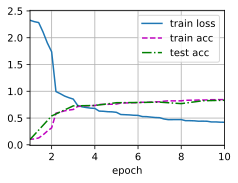

In [66]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [67]:
evaluate_accuracy_gpu(net, test_iter)

0.8319

ValueError: ignored

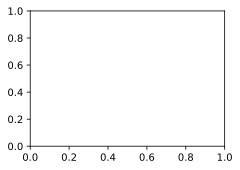

In [54]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())